In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



In [5]:
# Load the dataset
df = pd.read_csv("air_pollution_data.csv")

# Preprocessing: Convert 'dt' column to datetime format
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Feature engineering: Extracting features from timestamp
df['hour'] = df['dt'].dt.hour
df['day'] = df['dt'].dt.day
df['month'] = df['dt'].dt.month
df['year'] = df['dt'].dt.year

# Drop the original timestamp column
df.drop('dt', axis=1, inplace=True)





In [6]:
# Splitting the data into features and target variable
X = df.drop('main_aqi', axis=1)
y = df['main_aqi']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

Mean Squared Error: 0.0013695852534562215
R^2 Score: 0.9945206117247238


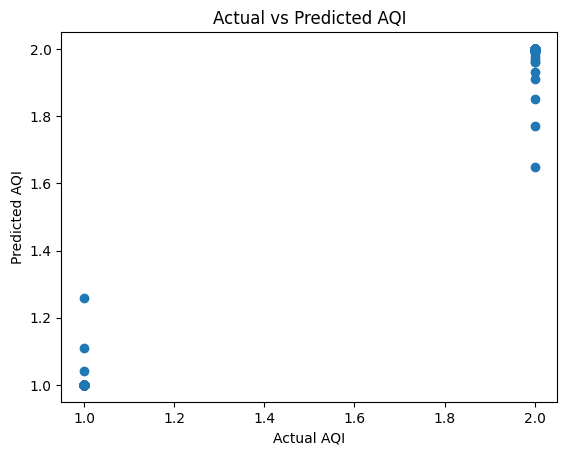

In [7]:
# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plotting actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.show()